In [1]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/dl_pojects/

/content/drive/MyDrive/dl_pojects


In [4]:
!pwd

/content/drive/MyDrive/dl_pojects


In [5]:
import os
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset
from model import resnet34

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [8]:
class MyImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        # Load tag file
        self.img_labels = pd.read_excel(annotations_file)  #'label', 'filename', 'name', 'price'
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Get picture path
        img_name = self.img_labels.iloc[idx]['filename']  # 'filename'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')  #  RGB
        # Check image shape and channel
        if image.mode != 'RGB':
            print(f"Warning: Image {img_path} is not RGB, mode is {image.mode}. Converting to RGB.")
            image = image.convert('RGB')
        if image.size[0] == 0 or image.size[1] == 0:
            raise ValueError(f"Error: Image {img_path} has zero width or height.")
        # Obtain complete label information
        label = self.img_labels.iloc[idx]['label']
        name = self.img_labels.iloc[idx]['name']
        price = self.img_labels.iloc[idx]['price']
        full_label = (label, f"{name}: {price}dkk")

        if self.transform:
            image = self.transform(image)

        return image, full_label

In [9]:
data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [10]:
train_dataset = MyImageDataset(
    annotations_file='train_data.xlsx',
    img_dir='train_imgs_augm',
    transform=data_transform['train']
)
trainLnum = len(train_dataset)
print(trainLnum)

validate_dataset = MyImageDataset(
    annotations_file='test_data.xlsx',
    img_dir='test_imgs',
    transform=data_transform['val']
)
valLnum = len(validate_dataset)
print(valLnum)

407
93


In [11]:
batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

Using 2 dataloader workers every process


In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
val_num = len(validate_dataset)

In [13]:
for images, labels_with_price in train_loader:
    print(f"Images: {images.size()}")
    print(f"Labels with Price: {labels_with_price}")
    break

Images: torch.Size([16, 3, 224, 224])
Labels with Price: [tensor([ 2, 30, 11, 26,  4, 19, 39, 10, 22, 30, 11,  6, 37, 25,  0, 27]), ('blanc: 45dkk', 'blanc_without: 45dkk', 'hazy_jane: 55dkk', 'ludwig_weiss: 65dkk', 'mokai: 45dkk', '7_up: 28dkk', 's_smith_cider: 55dkk', 'odense_pilsner: 28dkk', 'tuborg_guld: 40dkk', 'blanc_without: 45dkk', 'hazy_jane: 55dkk', 'ginger_beer: 55dkk', 'tuborg_groen: 28dkk', 'ludwig_dunkel: 65dkk', 'daura: 55dkk', 'pale_ale: 55dkk')]


In [ ]:
# import matplotlib.pyplot as plt
# from torchvision.transforms.functional import to_pil_image

# def plot_images_from_loader(data_loader, num_images=4):
#     images_shown = 0
#     plt.figure(figsize=(12, 8))

#     for images, labels_with_price in data_loader:
#         for i in range(num_images):
#             img = to_pil_image(images[i])  # Convert to PIL format
#             label = labels_with_price[1][i]
#             plt.subplot(1, num_images, i + 1)
#             plt.imshow(img)
#             plt.title(f"Label: {label}")
#             plt.axis('off')

#             images_shown += 1
#             if images_shown >= num_images:
#                 break
#         break
#     plt.tight_layout()
#     plt.show()

# plot_images_from_loader(train_loader, num_images=4)


In [14]:
try:
    del net
    del images
    del labels
except NameError:
    pass


net = resnet34()
model_weight_path = "./resnet34-pre.pth"
assert os.path.exists(model_weight_path), f"File {model_weight_path} does not exist."
net.load_state_dict(torch.load(model_weight_path, map_location='cpu'), strict=False)

# Modify the last layer
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 48)

net.to("cuda:0" if torch.cuda.is_available() else "cpu")


<ipython-input-14-ae782395535f>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_weight_path, map_location='cpu'), strict=False)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 

In [15]:
for images, labels_with_price in train_loader:
    labels = labels_with_price[0]
    print(f"Label range: {labels.min().item()} - {labels.max().item()}")
    break


Label range: 4 - 45


In [16]:
for images, labels_with_price in train_loader:
    labels = labels_with_price[0]
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")
    print(f"Label range: {labels.min().item()} - {labels.max().item()}")
    break


Image shape: torch.Size([16, 3, 224, 224]), dtype: torch.float32
Label shape: torch.Size([16]), dtype: torch.int64
Label range: 2 - 47


In [17]:
# define loss function
loss_function = nn.CrossEntropyLoss()
# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)
epochs = 7
best_acc = 0.0
save_path = './resNet34.pth'
train_steps = len(train_loader)
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Train
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels_with_price = data
        labels = labels_with_price[0]  # Extract the label tensor
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate the training set accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        correct_val = 0
        total_val = 0

        for val_data in val_bar:
            val_images, val_labels = val_data
            val_labels = val_labels[0] if isinstance(val_labels, list) else val_labels
            outputs = net(val_images.to(device))
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == val_labels.to(device)).sum().item()
            total_val += val_labels.size(0)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

    print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, train_accuracy, val_accuracy))

    if val_accuracy > best_acc:
        best_acc = val_accuracy
        torch.save(net.state_dict(), save_path)

print('Finished Training')


100%|██████████| 6/6 [00:00<00:00,  8.33it/s]
[epoch 1] train_loss: 3.788  train_accuracy: 0.106  val_accuracy: 0.602
100%|██████████| 6/6 [00:00<00:00,  7.41it/s]
[epoch 2] train_loss: 2.558  train_accuracy: 0.504  val_accuracy: 0.839
100%|██████████| 6/6 [00:00<00:00,  7.38it/s]
[epoch 3] train_loss: 1.682  train_accuracy: 0.754  val_accuracy: 0.935
100%|██████████| 6/6 [00:00<00:00,  8.46it/s]
[epoch 4] train_loss: 1.169  train_accuracy: 0.843  val_accuracy: 0.989
100%|██████████| 6/6 [00:01<00:00,  3.43it/s]
[epoch 5] train_loss: 0.848  train_accuracy: 0.899  val_accuracy: 1.000
100%|██████████| 6/6 [00:00<00:00,  8.37it/s]
[epoch 6] train_loss: 0.625  train_accuracy: 0.931  val_accuracy: 1.000
100%|██████████| 6/6 [00:00<00:00,  6.06it/s]
[epoch 7] train_loss: 0.575  train_accuracy: 0.919  val_accuracy: 0.989
Finished Training


# 新段落

In [17]:
print(f"After conversion - val_labels type: {type(val_labels)}")
print(f"val_labels content: {val_labels}")


After conversion - val_labels type: <class 'torch.Tensor'>
val_labels content: tensor([39, 38, 37, 36, 42, 41, 43, 28, 29, 30, 31, 33, 32])


In [ ]:
# validate
# net.eval()
# acc = 0.0  # accumulate accurate number / epoch
# with torch.no_grad():
#     val_bar = tqdm(validate_loader, file=sys.stdout)
#     for val_data in val_bar:
#         val_images, val_labels = val_data

#         val_labels = val_labels[0] if isinstance(val_labels, list) else val_labels

#         outputs = net(val_images.to(device))
#         predict_y = torch.max(outputs, dim=1)[1]
#         acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

#         val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1, epochs)

# val_accurate = acc / val_num
# print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
#       (epoch + 1, running_loss / train_steps, val_accurate))

# if val_accurate > best_acc:
#     best_acc = val_accurate
#     torch.save(net.state_dict(), save_path)

# print('Finished Training')



valid epoch[3/3]: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]
[epoch 3] train_loss: 1.675  val_accuracy: 0.957
Finished Training


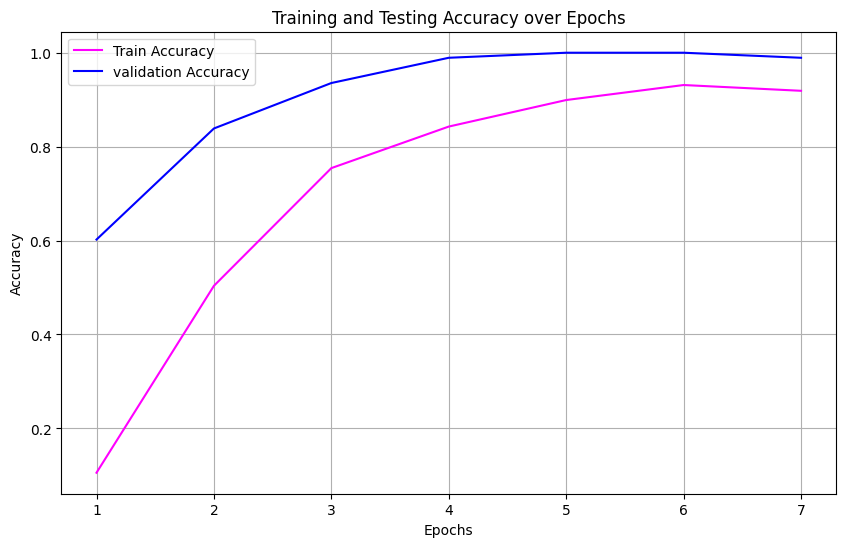

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy graphs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='magenta')
plt.plot(range(1, epochs + 1), val_accuracies, label='validation Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()